In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
dis_sph(N=1000)[0].shape

(1000, 3)

In [2]:
from climate.core import EPW
from climate.helpers import *
a = EPW("./tests/weatherfile.epw")
a.read()

In [3]:
# Run gendaymtx and create diffuse and direct sky matrices
a.run_gendaymtx(reinhart=False)

WEA file created: C:\Users\trist\github\climate\tests\weatherfile.wea
Diffuse radiation matrix created: C:\Users\trist\github\climate\tests\weatherfile.diffmtx
Direct radiation matrix created: C:\Users\trist\github\climate\tests\weatherfile.dirmtx


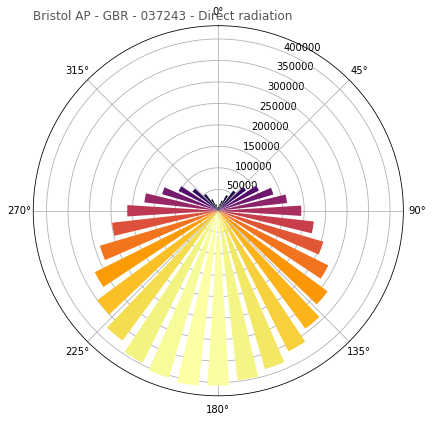

In [6]:
from climate.old_plot import *

radiation_rose(a, 0)

In [12]:
np.degrees(a.radiation_rose_angles)[::-1]

array([350., 340., 330., 320., 310., 300., 290., 280., 270., 260., 250.,
       240., 230., 220., 210., 200., 190., 180., 170., 160., 150., 140.,
       130., 120., 110., 100.,  90.,  80.,  70.,  60.,  50.,  40.,  30.,
        20.,  10.,   0.])

In [8]:
from climate.radiance import *

_dir, _dif = run_gendaymtx(a.wea_file, reinhart=True)

Calculating radiation matrices


In [10]:
# Ground temperature test
a.run_ground_temperatures(depth=0.5)

a.ground_temperature_at_depth.plot()


Ground temperature calculated


Wet-bulb temperature calculated
Enthalpy calculated
Humidity ratio calculated


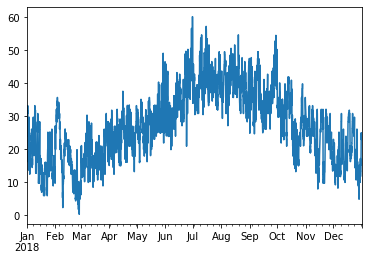

In [12]:
# Psychrometric test
a.run_psychrometrics()

a.enthalpy.plot()

In [10]:
# Sun position test
a.run_sunposition()

a.solar_altitude.plot()

'"Downloaded from Climate.Onebuilding.org -- Ground temps represent undisturbed earth temperatures - calculated from this weather data."'

In [19]:
# Preprocess

df = a.df

from climate.old import *

# Calculate local wind speed
df["WindSpeed2m"] = [wind_speed_at_height(ws=i, h1=10, h2=2) for i in df.wind_speed]
print("Wind speed calculated")

# Calculate the solar altitude/azimuth
df["SolarAltitude"] = [solar_altitude(a.latitude, a.longitude, i.year, i.month, i.day, i.hour, a.time_zone, i.minute, i.second) for i in df.index]
print("Sun altitudes calculated")
df["SolarAzimuth360"] = [solar_azimuth(a.latitude, a.longitude, i.year, i.month, i.day, i.hour, a.time_zone, i.minute, i.second) for i in df.index]
df["SolarAzimuth"] = [float(l) if float(l) < 180 else float(360-l) for l in df.SolarAzimuth360.values]
print("Sun azimuths calculated")

# Solar Adj MRT
df["SolarAdjustedMeanRadiantTemperature"] = df.apply(
    lambda x: solar_adjusted_mean_radiant_temperature(
        dry_bulb_temperature=x.dry_bulb_temperature, 
        direct_normal_radiation=x.direct_normal_radiation, 
        diffuse_horizontal_radiation=x.diffuse_horizontal_radiation, 
        global_horizontal_radiation=x.global_horizontal_radiation, 
        solar_altitude=x.SolarAltitude, 
        solar_azimuth=x.SolarAzimuth, 
        ground_reflectivity=0.3, 
        clothing_absorbtivity=0.7, 
        shading_transmissivity=1
    ), axis=1
)
print("SolarAdjustedMeanRadiantTemperature calculated")

# UTCI
df["UniversalThermalClimateIndex"] = df.apply(
    lambda x: universal_thermal_climate_index(
        air_temperature=x["dry_bulb_temperature"], 
        air_velocity=x["WindSpeed2m"],
        mean_radiant_temperature=x["SolarAdjustedMeanRadiantTemperature"],
        relative_humidity=x["relative_humidity"]
    ), 
    axis=1
)
print("UTCI calculated")

# Humidity ratio
df["HumidityRatio"] = df.apply(lambda x: humidity_ratio_relative_humidity(dry_bulb_temperature=x["dry_bulb_temperature"], relative_humidity=x["relative_humidity"]/100, pressure=x["atmospheric_station_pressure"]/1000), axis=1)
print("Humidity ratio calculated")

# Enthalpy
df["Enthalpy"] = df.apply(lambda x: enthalpy_relative_humidity(dry_bulb_temperature=x["dry_bulb_temperature"], relative_humidity=x["relative_humidity"]/100, pressure=x["atmospheric_station_pressure"]/1000), axis=1)
print("Enthalpy calculated")

# Wet-bulb temperature
df["WetBulbTemperature"] = df.apply(lambda x: wet_bulb_temperature_relative_humidity(dry_bulb_temperature=x["dry_bulb_temperature"], relative_humidity=x["relative_humidity"]/100, pressure=x["atmospheric_station_pressure"]/1000), axis=1)
print("WetBulb calculated")

df["City"] = a.city
df["Country"] = a.country
df["StationID"] = a.station_id

# Set the base folder
directory = "./Charts"

# Generate output directory
output_directory = generate_directory(os.path.join(directory, a.filepath.replace(".epw", "")))

Wind speed calculated
Sun altitudes calculated
Sun azimuths calculated
SolarAdjustedMeanRadiantTemperature calculated
UTCI calculated
Humidity ratio calculated
Enthalpy calculated
WetBulb calculated


In [5]:
bh = BuroHappold()
bh.colors["official"]["BrandGreen"]

rgb_to_hex(bh.colors["official"]["BrandGreen"])
rgb_to_hex([0.5, 0.5, 0.8])

'#7f7fcc'

In [20]:
from climate.old_plot import *

# Run the Psychrometric chart generator
psychrometric_chart(df, cm=gen_cmap([bh_colors["BH_DarkBlue"], bh_colors["BH_Orange"], bh_colors["BH_BrightRed"]], N=1000), close=True, savepath=os.path.join(output_directory, "Psychrometric.png"))

Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Psychrometric.png


In [21]:
# Run some boring, generic heatmaps  
weather_heatmap(df, "global_horizontal_radiation", cmap=gen_cmap([[255, 255, 255], bh_colors["BH_Orange"]], N=500), savepath=os.path.join(output_directory, "GlobalHorizontalRadiation.png"), close=True)
weather_heatmap(df, "dry_bulb_temperature", cmap=gen_cmap([[255, 255, 255], bh_colors["BH_BrightRed"]], N=500), savepath=os.path.join(output_directory, "DryBulbTemperature.png"), close=True)
weather_heatmap(df, "relative_humidity", cmap=gen_cmap([bh_colors["BH_DarkBlue"], [255, 255, 255]], N=500, r=True), savepath=os.path.join(output_directory, "RelativeHumidity.png"), close=True)
weather_heatmap(df, "dew_point_temperature", cmap=gen_cmap([bh_colors["BH_Purple"], [255, 255, 255]], N=500, r=True), savepath=os.path.join(output_directory, "DewPointTemperature.png"), close=True)


Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\GlobalHorizontalRadiation.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\DryBulbTemperature.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\RelativeHumidity.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\DewPointTemperature.png


In [22]:
# Run some more interesting UTCI frequency plots
utci_frequency(df, hours=['08:00', '22:00'], savepath=os.path.join(output_directory, "UTCI_histogram_0800_2200.png"), close=True)
utci_frequency(df, hours=['00:00', '23:59'], savepath=os.path.join(output_directory, "UTCI_histogram_0000_2359.png"), close=True)


Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\UTCI_histogram_0800_2200.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\UTCI_histogram_0000_2359.png


In [23]:
# Run a nice, pretty UTCI heatmap
utci_heatmap(df, savepath=os.path.join(output_directory, "UTCI_heatmap.png"), close=True)

Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\UTCI_heatmap.png


In [24]:
_seasons = ["Annual", "Spring", "Summer", "Autumn", "Winter"]
_times = ["Daily"]

# Run some windroses per seaon and time period
for s in _seasons:
    for t in _times:
        windroset(df, seasonal_period=s, day_period=t, variable="wind_speed", cmap=gen_cmap([bh_colors["BH_Green"], bh_colors["BH_DarkBlue"], bh_colors["BH_DarkRed"]], N=500, r=False), cls=True, savepath=os.path.join(output_directory, "Windrose_{}_{}_{}.png".format(s, t, "WindSpeed")))


Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Windrose_Annual_Daily_WindSpeed.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Windrose_Spring_Daily_WindSpeed.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Windrose_Summer_Daily_WindSpeed.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Windrose_Autumn_Daily_WindSpeed.png
Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Windrose_Winter_Daily_WindSpeed.png


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

Saving to C:\Users\tgerrish\Documents\GitHub\climate\tests\IRL_EM_Dublin.AP.039690_TMYx.2003-2017\Diurnal.png


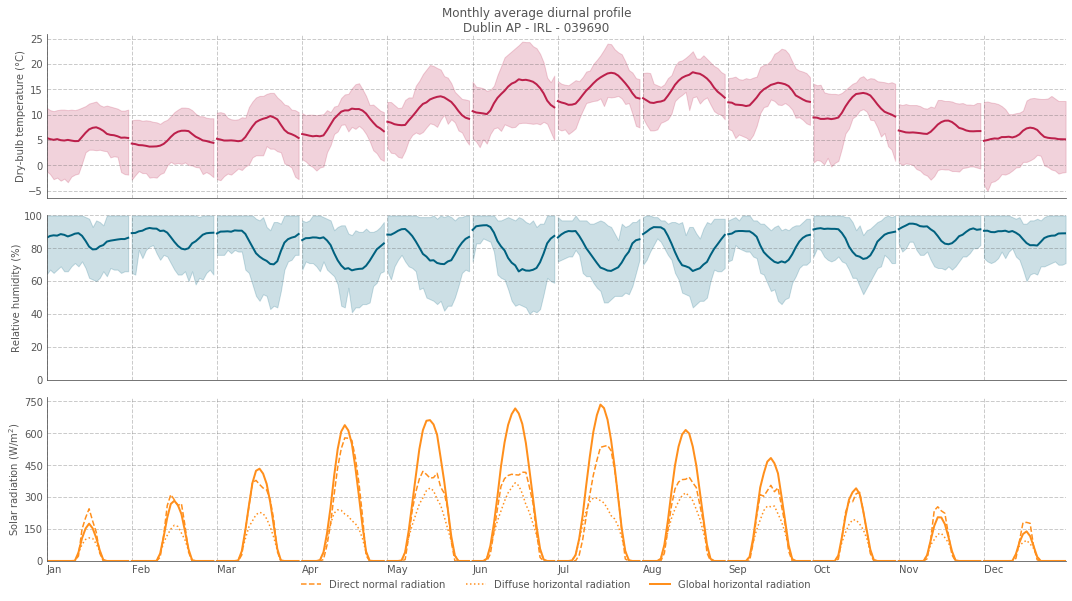

In [25]:
# Run a monthly diurnal summary plot
monthly_diurnal_plot(df, savepath=os.path.join(output_directory, "Diurnal.png"), close=True)

In [59]:
a.city.__ne__

<method-wrapper '__ne__' of str object at 0x0000019F63469870>

In [39]:
# pd.datetime.utcoffset()
pd.datetime.utcoffset
datetime.utcoffset(12)

TypeError: descriptor 'utcoffset' requires a 'datetime.datetime' object but received a 'int'

In [7]:
import pandas as pd
time_zone = 3.5
dti = pd.date_range(start="2018-01-01 00:00:00", end="2019-01-01 00:00:00", freq="60T", closed="left")

dti.tz_localize('UTC').tz_convert(int(0 * 60 * 60))

DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 01:00:00+00:00',
               '2018-01-01 02:00:00+00:00', '2018-01-01 03:00:00+00:00',
               '2018-01-01 04:00:00+00:00', '2018-01-01 05:00:00+00:00',
               '2018-01-01 06:00:00+00:00', '2018-01-01 07:00:00+00:00',
               '2018-01-01 08:00:00+00:00', '2018-01-01 09:00:00+00:00',
               ...
               '2018-12-31 14:00:00+00:00', '2018-12-31 15:00:00+00:00',
               '2018-12-31 16:00:00+00:00', '2018-12-31 17:00:00+00:00',
               '2018-12-31 18:00:00+00:00', '2018-12-31 19:00:00+00:00',
               '2018-12-31 20:00:00+00:00', '2018-12-31 21:00:00+00:00',
               '2018-12-31 22:00:00+00:00', '2018-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq='60T')